In [1]:
import root_pandas as rp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ROOT
import array
import matplotlib
from matplotlib import rc #for custom label formatting
'''Make larger axes labels for plots for papers and such'''
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams["figure.titlesize"] = 30
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

Welcome to JupyROOT 6.22/02


In [2]:
#B = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_events.root', key='B')

e = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='e')
mu = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='mu')
truth_e = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='e_truth')
truth_mu = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='mu_truth')
truth_B = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='B_truth')
e2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='e')
mu2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='mu')
truth_e2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='e_truth')
truth_mu2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='mu_truth')
truth_B2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='B_truth')

In [26]:
e_red = e.loc[(e['muIDBelleQuality']<0.01) & (e['eIDBelle']>0.99)]
mu_red = mu.loc[(mu['muIDBelleQuality']>0.9) & (mu['muIDBelle']>0.99) & (mu['eIDBelle']<0.01)]
lepton = e_red.append(mu_red).sort_values(by='__event__')
e_red2 = e2.loc[(e2['muIDBelleQuality']<0.001) & (e2['muIDBelle']<0.01) & (e2['eIDBelle']>0.99)]
mu_red2 = mu2.loc[(mu2['muIDBelleQuality']>0.9) & (mu2['muIDBelle']>0.99) & (mu2['eIDBelle']<0.01)]
lepton2 = e_red2.append(mu_red2).sort_values(by='__event__')

In [28]:
len(lepton2.loc[lepton2['isSignal']!=1])/len(lepton2)

0.006682684102038941

In [18]:
def create_lepton_analysis_dataframe(df, Bs = truth_B):
    df['counts/event'] = 1 #placeholder to select on events with 2 reconstructed dfs
    tab = pd.pivot_table(df, values='counts/event', index=['__event__'], aggfunc=np.sum) #determine # of dfs in event
    tab.loc[tab['counts/event'] == 2].index.to_numpy() #only keep event numbers with 2 reconstructed dfs
    pairs = df.loc[df['__event__'].isin(tab.loc[tab['counts/event']==2].index.to_numpy())] #dataframe with event-wise pairs of dfs
    pairs['truth_dz'] = Bs.loc[Bs['__event__'].isin(pairs['__event__'].to_numpy())]['mcDecayVertexFromIPZ'].to_numpy()
    pairs['B_PDG'] = Bs.loc[Bs['__event__'].isin(pairs['__event__'].to_numpy())]['mcPDG'].to_numpy()
    tmp = pairs.groupby('__event__').diff() #group by differences of events to get quantities like deltaT and to determine mistag
    sums = pairs.groupby('__event__').sum()
    tmp.dropna(subset = ['z'], inplace = True)
    tmp.index = [i for i in range(0,len(tmp))]
    tmp['deltaT'] = tmp['dz']/(0.425*3e10)*1e12
    tmp['mcDeltaT'] = tmp['truth_dz']/(0.425*3e10)*1e12
    tmp['deltaT'] = np.abs(tmp['deltaT'])
    tmp['mcDeltaT'] = np.abs(tmp['mcDeltaT'])
    sums.dropna(subset = ['z'], inplace = True)
    sums.index = [i for i in range(0,len(sums))]
    sums['sumT'] = sums['dz']/(0.425*3e10)*1e12
    sums['mcSumT'] = sums['truth_dz']/(0.425*3e10)*1e12
    tmp['sumT'] = np.abs(sums['sumT'])
    tmp['mcSumT'] = np.abs(sums['mcSumT'])
    tmp['mistag'] = 0
    index = tmp.loc[((tmp['charge']==0) & (tmp['B_PDG']!=0)) | ((tmp['charge']!=0) & (tmp['B_PDG']==0))].index.to_numpy()
    tmp['mistag'][index] = 1
    tmp['SF']=0
    tmp['OF']=0
    tmp['SF_truth']=0
    tmp['OF_truth']=0
    index1 = tmp.loc[tmp['charge']==0].index.to_numpy()
    index2 = tmp.loc[tmp['charge']!=0].index.to_numpy()
    tindex1 = tmp.loc[tmp['B_PDG']==0].index.to_numpy()
    tindex2 = tmp.loc[tmp['B_PDG']!=0].index.to_numpy()
    tmp['SF'][index1]=1
    tmp['OF'][index2]=1
    tmp['SF_truth'][tindex1]=1
    tmp['OF_truth'][tindex2]=1
    tmp['counts'] = 1 #to count events in grouped bins
    test = tmp.groupby(pd.cut(tmp['deltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum()
    test_err = np.sqrt(tmp.groupby(pd.cut(tmp['deltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum())
    test_truth = tmp.groupby(pd.cut(tmp['mcDeltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum()
    test_truth_err = np.sqrt(tmp.groupby(pd.cut(tmp['mcDeltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum())
    test['A'] = (test['OF']-test['SF'])/(test['OF']+test['SF'])
    test_err['A'] = np.abs(test['A'])*np.sqrt((np.sqrt(test_err['OF']**2+test_err['SF']**2)/(test['OF']-test['SF']))**2 + (np.sqrt(test_err['OF']**2+test_err['SF']**2)/(test['OF']+test['SF']))**2)
    test['A_truth'] = (test['OF_truth']-test['SF_truth'])/(test['OF_truth']+test['SF_truth'])
    test_err['A_truth'] = np.abs(test['A_truth'])*np.sqrt((np.sqrt(test_err['OF_truth']**2+test_err['SF_truth']**2)/(test['OF_truth']-test['SF_truth']))**2 + (np.sqrt(test_err['OF_truth']**2+test_err['SF_truth']**2)/(test['OF_truth']+test['SF_truth']))**2)
    test_truth['A'] = (test_truth['OF']-test_truth['SF'])/(test_truth['OF']+test_truth['SF'])
    test_truth_err['A'] = np.abs(test_truth['A'])*np.sqrt((np.sqrt(test_truth_err['OF']**2+test_truth_err['SF']**2)/(test_truth['OF']-test_truth['SF']))**2 + (np.sqrt(test_truth_err['OF']**2+test_truth_err['SF']**2)/(test_truth['OF']+test_truth['SF']))**2)
    test_truth['A_truth'] = (test_truth['OF_truth']-test_truth['SF_truth'])/(test_truth['OF_truth']+test_truth['SF_truth'])
    test_truth_err['A_truth'] = np.abs(test_truth['A_truth'])*np.sqrt((np.sqrt(test_truth_err['OF_truth']**2+test_truth_err['SF_truth']**2)/(test_truth['OF_truth']-test_truth['SF_truth']))**2 + (np.sqrt(test_truth_err['OF_truth']**2+test_truth_err['SF_truth']**2)/(test_truth['OF_truth']+test_truth['SF_truth']))**2)
    
    return tmp, test[['OF','SF','OF_truth','SF_truth','A','A_truth','counts','mistag']], test_err[['OF','SF','OF_truth','SF_truth','A','A_truth','counts','mistag']], test_truth[['OF','SF','OF_truth','SF_truth','A','A_truth','counts','mistag']], test_truth_err[['OF','SF','OF_truth','SF_truth','A','A_truth','counts','mistag']]

data = create_lepton_analysis_dataframe(lepton, truth_B)[0]
data2 = create_lepton_analysis_dataframe(lepton2, truth_B2)[0]
signal = e.loc[e['isSignal']==1].append(mu.loc[mu['isSignal']==1]).sort_values(by='__event__')
signal2 = e2.loc[e2['isSignal']==1].append(mu2.loc[mu2['isSignal']==1]).sort_values(by='__event__')
truth = create_lepton_analysis_dataframe(signal, truth_B)[0]
truth2 = create_lepton_analysis_dataframe(signal2, truth_B2)[0]

/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [19]:
dataSF = truth.loc[truth['SF']==1]
dataOF = truth.loc[truth['SF']!=1]
truthSF = truth.loc[truth['SF_truth']==1]
truthOF = truth.loc[truth['SF_truth']!=1]
dataSF2 = data2.loc[data2['SF']==1]
dataOF2 = data2.loc[data2['SF']!=1]
truthSF2 = truth2.loc[truth2['SF_truth']==1]
truthOF2 = truth2.loc[truth2['SF_truth']!=1]

In [20]:
(dataOF2['mistag'].sum()+ dataSF2['mistag'].sum())/(len(dataOF2) + len(dataSF2))

0.008554520419523056

In [21]:
dataOF2['mistag'].sum()/len(dataOF2),dataSF2['mistag'].sum()/len(dataSF2)

(0.001438538444939941, 0.03982300884955752)

In [ ]:
#response_OF = ROOT.RooUnfoldResponse(11, array.array('d',low_edges))
#response_SF = ROOT.RooUnfoldResponse(11, array.array('d',low_edges))
#response_OF = ROOT.RooUnfoldResponse(20, 0, 20)
#response_SF = ROOT.RooUnfoldResponse(20, 0, 20)

In [29]:
def make_response_matrix(OF_data,OF_truth,SF_data,SF_truth,physics_model): #physics models: QM and SD
    if physics_model.lower() == 'qm':
        low_edges = [0,0.5,1,2,3,4,5,6,7,9,13,20]
        key = 'deltaT'
        mckey = 'mcDeltaT'
    else:
        low_edges = [0,6,12,20,30,45,60,90,120,150,200,300]
        key = 'sumT'
        mckey = 'mcSumT'
    truthHistOF = ROOT.TH1D("","",11,array.array('d',low_edges))
    measHistOF = ROOT.TH1D("","",11,array.array('d',low_edges))
    truthHistSF = ROOT.TH1D("","",11,array.array('d',low_edges))
    measHistSF = ROOT.TH1D("","",11,array.array('d',low_edges))
    response_OF = ROOT.RooUnfoldResponse(measHistOF,truthHistOF)
    response_SF = ROOT.RooUnfoldResponse(measHistSF,truthHistSF)
    for i in range(0,min(len(OF_data),len(OF_truth))):
        truthHistOF.Fill(OF_truth[mckey].iloc[i])
        measHistOF.Fill(OF_data[key].iloc[i])
        response_OF.Fill(OF_data[key].iloc[i],OF_truth[mckey].iloc[i])
    for i in range(0,min(len(SF_data),len(SF_truth))):
        truthHistSF.Fill(SF_truth[mckey].iloc[i])
        measHistSF.Fill(SF_data[key].iloc[i])
        response_SF.Fill(SF_data[key].iloc[i],SF_truth[mckey].iloc[i])
    return response_OF, response_SF, truthHistOF, truthHistSF, measHistOF, measHistSF

In [30]:
response_OF, response_SF, truthHistOF, truthHistSF, measHistOF, measHistSF = make_response_matrix(truthOF,truthOF,truthSF,truthSF,'QM') #call truth in {OF,SF}_data to avoid mistagging in response matrix
response_OF_sum, response_SF_sum, truthHistOF_sum, truthHistSF_sum, measHistOF_sum, measHistSF_sum = make_response_matrix(truthOF,truthOF,truthSF,truthSF,'SD')

In [33]:
def plot_original_distributions(flavor = 'OF', model = 'QM', save=False):
    response_OF, response_SF, truthHistOF, truthHistSF, measHistOF, measHistSF = make_response_matrix(truthOF,truthOF,truthSF,truthSF,model)
    if flavor.lower() == 'of':
        truthHist = truthHistOF
        measHist = measHistOF
    else:
        truthHist = truthHistSF
        measHist = measHistSF
    c = ROOT.TCanvas()
    truthHist.SetStats(0)
    truthHist.SetFillColorAlpha(7,0)
    truthHist.SetLineColor(2)
    truthHist.SetLineWidth(2)
    measHist.SetLineWidth(2)
    truthHist.DrawClone()
    truthHist.SetTitle("%s Distributions"%(flavor))
    truthHist.GetXaxis().SetTitle(r'\Delta t  [ps]')
    truthHist.GetXaxis().SetTitleSize(0.05)
    truthHist.GetXaxis().SetLabelSize(0.05)
    truthHist.GetYaxis().SetLabelSize(0.05)
    truthHist.GetXaxis().SetTitleOffset(0.9)
    measHist.SetFillColorAlpha(42,0)
    truthHist.DrawClone()
    measHist.DrawClone("same")
    leg = ROOT.TLegend(.55,0.7,.9,.9)
    leg.AddEntry(truthHist,"True Distribution")
    leg.AddEntry(measHist,"Measured")
    leg.DrawClone()
    if save == True:
        c.SaveAs('Original_distributions_%s_%s.png'%(model,flavor))
    return c


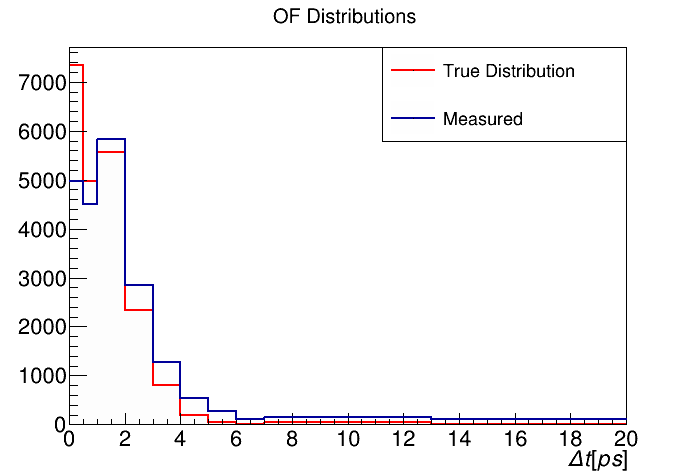

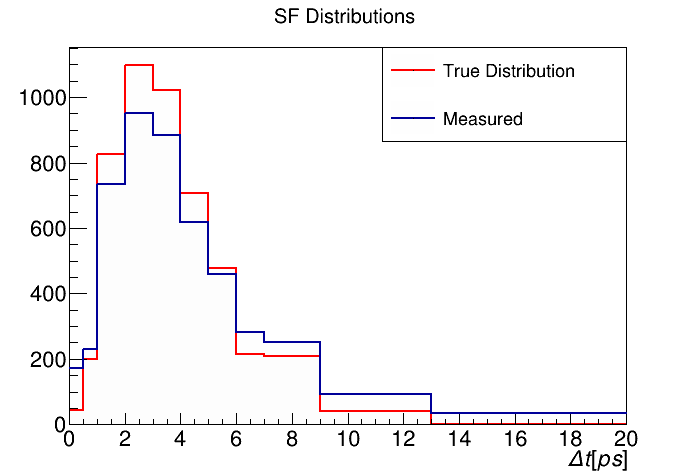

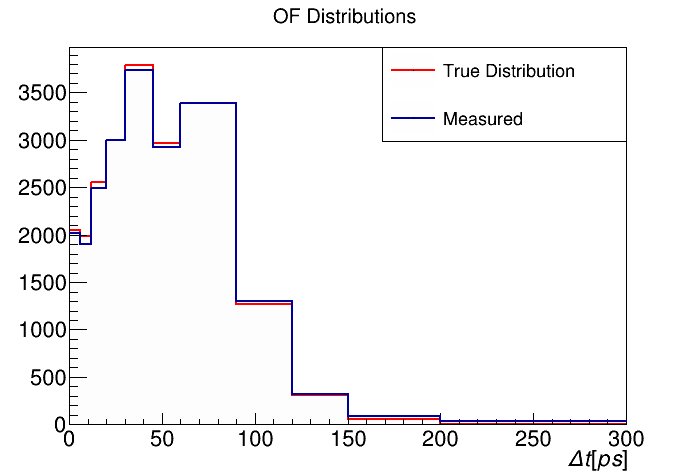

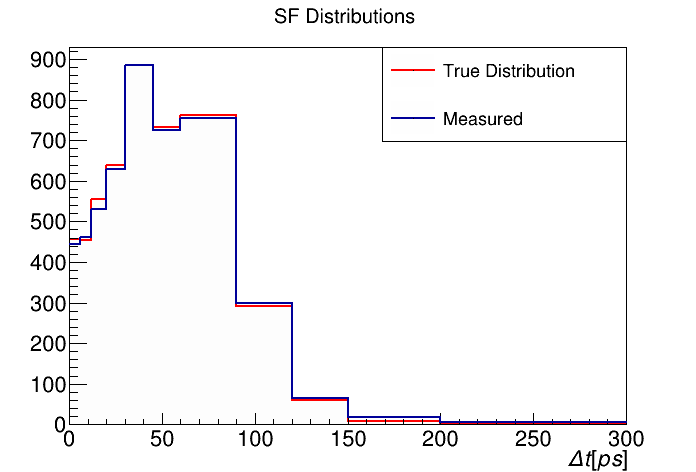

In [34]:
c = plot_original_distributions(flavor = 'OF',model = 'QM')
c.Draw()
c1 = plot_original_distributions('SF','QM')
c1.Draw()
c2 = plot_original_distributions('OF','SD')
c2.Draw()
c3 = plot_original_distributions('SF','SD')
c3.Draw()

In [35]:
def plot_response_matrix(flavor = 'OF', model = 'QM', save=False):
    response_OF, response_SF, truthHistOF, truthHistSF, measHistOF, measHistSF = make_response_matrix(truthOF,truthOF,truthSF,truthSF,model)
    if flavor.lower() == 'of':
        RSF = response_OF.HresponseNoOverflow()
    else:
        RSF = response_SF.HresponseNoOverflow()
    c = ROOT.TCanvas()
    #ROOT.gPad.SetLogz()
    RSF.SetStats(0)
    RSF.SetTitle("Response (%s)"%(flavor))
    RSF.GetXaxis().SetTitle(r'\Delta t_{meas} [ps]')
    RSF.GetXaxis().SetTitleSize(0.05)
    RSF.GetXaxis().SetLabelSize(0.05)
    RSF.GetXaxis().SetTitleOffset(0.9)
    RSF.GetYaxis().SetTitle(r'\Delta t_{truth} [ps]')
    RSF.GetYaxis().SetTitleSize(0.05)
    RSF.GetYaxis().SetLabelSize(0.05)
    RSF.GetYaxis().SetTitleOffset(1)
    RSF.DrawClone("colz")
    if save == True:
        c.SaveAs('Response_%s_%s.png'%(model,flavor))
    return c


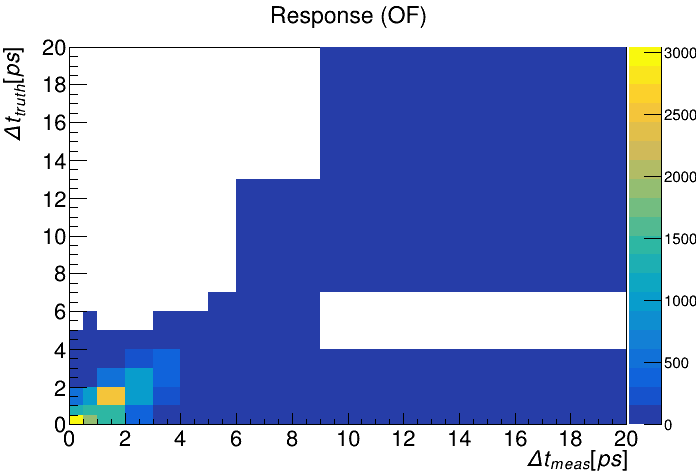

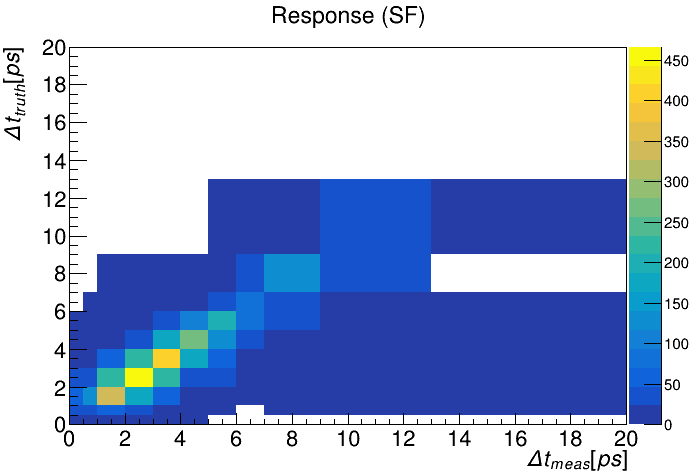

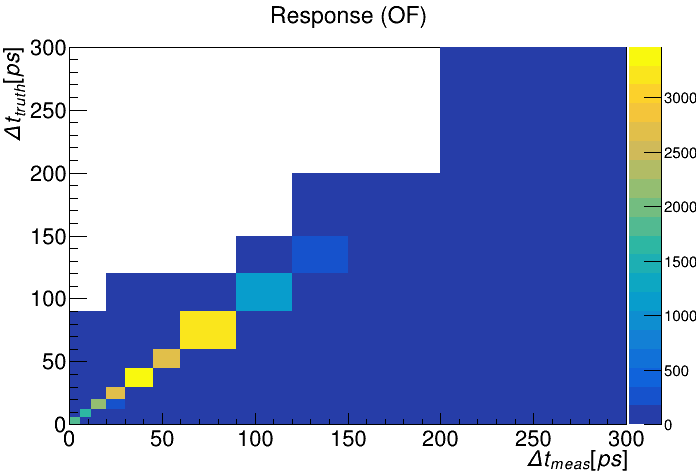

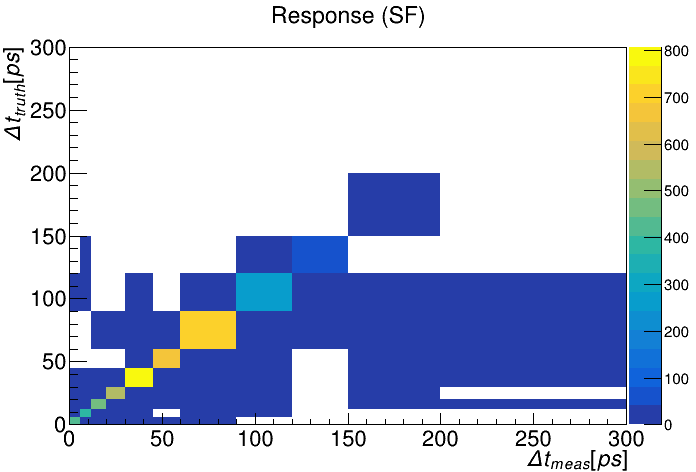

In [36]:
c = plot_response_matrix(flavor = 'OF',model = 'QM')
c.Draw()
c1 = plot_response_matrix('SF','QM')
c1.Draw()
c2 = plot_response_matrix('OF','SD')
c2.Draw()
c3 = plot_response_matrix('SF','SD')
c3.Draw()

# Use different data and truth sets for testing

In [37]:
def unfold(OF_data, OF_truth, SF_data, SF_truth, model='QM', method = 'SVD', OF_reg = 4, SF_reg = 4, #regularization params
           train_OF_data = truthOF, train_OF_truth = truthOF, 
           train_SF_data = truthSF, train_SF_truth = truthSF): #physics models: QM and SD, method = 'SVD' and 'Bayes'
    #First make response matrix
    response_OF = make_response_matrix(train_OF_data,train_OF_truth,train_SF_data,train_SF_truth,model)[0]
    response_SF = make_response_matrix(train_OF_data,train_OF_truth,train_SF_data,train_SF_truth,model)[1]
    
    #make and fill data histograms
    if model.lower() == 'qm':
        low_edges = [0,0.5,1,2,3,4,5,6,7,9,13,20]
        key = 'deltaT'
        mckey = 'mcDeltaT'
    else:
        low_edges = [0,6,12,20,30,45,60,90,120,150,200,300]
        key = 'sumT'
        mckey = 'mcSumT'
    hTrueOF = ROOT.TH1D("","",11,array.array('d',low_edges))
    hMeasOF = ROOT.TH1D("","",11,array.array('d',low_edges))
    hTrueSF = ROOT.TH1D("","",11,array.array('d',low_edges))
    hMeasSF = ROOT.TH1D("","",11,array.array('d',low_edges))  
    
    for i in range(0,min(len(OF_data),len(OF_truth))):
        xt = OF_truth[mckey].to_numpy()[i]
        x = np.abs(OF_data[key]).to_numpy()[i]
        hTrueOF.Fill(xt)
        hMeasOF.Fill(x)
    for i in range(0,min(len(SF_data),len(SF_truth))):
        xt = SF_truth[mckey].to_numpy()[i]
        x = np.abs(SF_data[key]).to_numpy()[i]
        hTrueSF.Fill(xt)
        hMeasSF.Fill(x)
    
    if method.lower() == 'svd':
        unfoldOF = ROOT.RooUnfoldSvd(response_OF, hMeasOF, OF_reg)
        unfoldSF = ROOT.RooUnfoldSvd(response_SF, hMeasSF, SF_reg)
    elif method.lower() == 'bayes':
        unfoldOF = ROOT.RooUnfoldBayes(response_OF, hMeasOF, OF_reg)
        unfoldSF = ROOT.RooUnfoldBayes(response_SF, hMeasSF, SF_reg)
    elif method.lower() == 'invert':
        unfoldOF = ROOT.RooUnfoldInvert(response_OF, hMeasOF)
        unfoldSF = ROOT.RooUnfoldInvert(response_SF, hMeasSF)
    elif method.lower() == 'regularized':
        unfoldOF = ROOT.RooUnfoldTUnfold(response_OF, hMeasOF)
        unfoldSF = ROOT.RooUnfoldTUnfold(response_SF, hMeasSF)
    else:
        unfoldOF = ROOT.RooUnfoldBinByBin(response_OF, hMeasOF)
        unfoldSF = ROOT.RooUnfoldBinByBin(response_SF, hMeasSF)

    hRecoOF = unfoldOF.Hreco()
    hRecoSF = unfoldSF.Hreco()

    return hRecoOF, hRecoSF, hTrueOF, hTrueSF, hMeasOF, hMeasSF

In [38]:
def plot_unfold(flavor = 'OF', model = 'QM', method = 'SVD', OF_reg = 5, SF_reg = 6, save = False, OF_data = dataOF2, OF_truth = truthOF2, SF_data = dataSF2, SF_truth = truthSF2):
    hRecoOF, hRecoSF, hTrueOF, hTrueSF, hMeasOF, hMeasSF = unfold(OF_data = OF_data, OF_truth = OF_truth, SF_data = SF_data, SF_truth = SF_truth, 
                                                              model = model, method = method, OF_reg = OF_reg, SF_reg = SF_reg)
    c = ROOT.TCanvas()
    if flavor.lower() == 'of':
        reco = hRecoOF
        truth = hTrueOF
        meas = hMeasOF
        reco.SetTitle("Unfold Response (OF) %s %s"%(model,method))
    else:
        reco = hRecoSF
        truth = hTrueSF
        meas = hMeasSF
        reco.SetTitle("Unfold Response (SF) %s %s"%(model,method))
    
    reco.SetStats(0)
    if model.lower() != 'qm':
        reco.GetXaxis().SetTitle(r't1 + t2 [ps]')
    else:
        reco.GetXaxis().SetTitle(r'\Delta t [ps]')
    reco.SetMinimum(0.9)
    reco.GetXaxis().SetTitleSize(0.05)
    reco.GetXaxis().SetLabelSize(0.05)
    reco.GetYaxis().SetLabelSize(0.05)
    reco.GetXaxis().SetTitleOffset(0.9)
    truth.SetLineColor(2)
    reco.SetLineColor(1)
    truth.SetLineWidth(2)
    meas.SetLineWidth(2)
    reco.SetMarkerStyle(20)
    reco.SetMarkerSize(0.5)
    reco.DrawClone()
    truth.DrawClone("same")
    meas.DrawClone("same")
    leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
    leg.AddEntry(truth, "True distribution","pl")
    leg.AddEntry(meas, "Measured distribution", "pl")
    leg.AddEntry(reco, "Unfolded distribution")
    leg.DrawClone()
    if save == True:
        c.SaveAs('unfold_%s_%s_%s.png'%(model,flavor,method))
    return c

In [91]:
len(truthOF),len(truthSF)

(21356, 4845)

SVD init 11 x 11 bins, kreg=2
SVD init 11 x 11 bins, kreg=2
SVD init 11 x 11 bins, kreg=2
SVD init 11 x 11 bins, kreg=2


Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000351
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000107
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000351
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000107


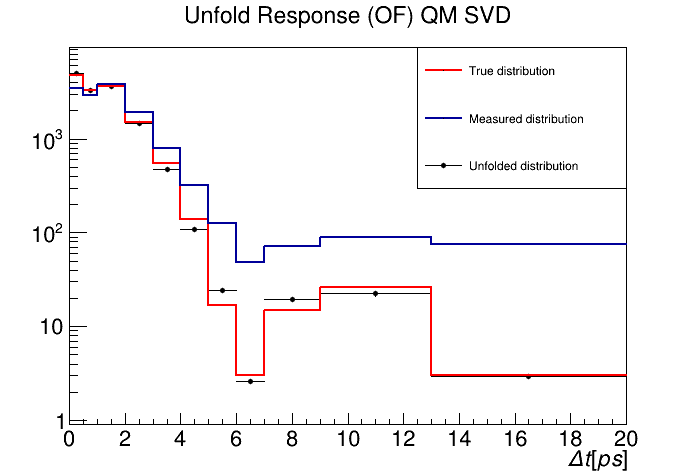

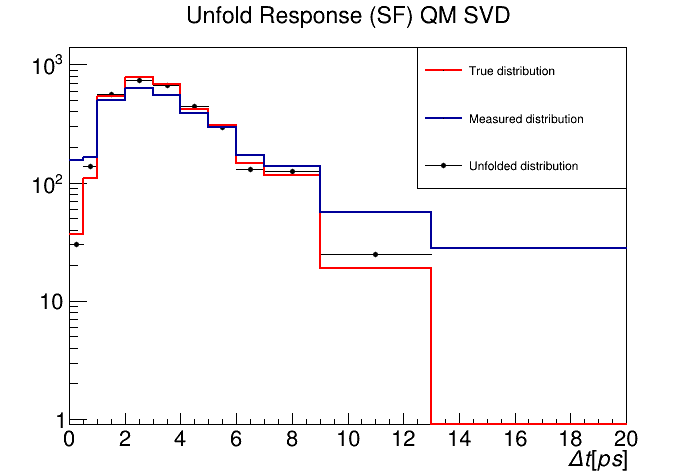

In [87]:
c = plot_unfold('OF', 'QM', 'SVD', 2,2)
ROOT.gPad.SetLogy()
c.Draw()
c1 = plot_unfold('SF', 'QM', 'SVD', 2,2)
ROOT.gPad.SetLogy()
c1.Draw()
#c2 = plot_unfold('OF', 'QM', 'SVD', 4,2)
#ROOT.gPad.SetLogy()
#c2.Draw()
#c3 = plot_unfold('OF', 'QM', 'Bayes', 4,2)
#ROOT.gPad.SetLogy()
#c3.Draw()

In [51]:
def get_asymmetries(model, OF_reg = 5, SF_reg = 6, OF_data = dataOF2, OF_truth = truthOF2, SF_data = dataSF2, SF_truth = truthSF2):
    
    hRecoOF, hRecoSF, hTrueOF, hTrueSF, hMeasOF, hMeasSF = unfold(OF_data = OF_data, OF_truth = OF_truth, SF_data = SF_data, SF_truth = SF_truth, 
                                                              model = model, method = 'SVD', OF_reg = OF_reg, SF_reg = SF_reg)
    vals = []
    vals_meas = []
    vals_truth = []
    for i in range(1,12):
        try:
            vals.append((hRecoOF.GetBinContent(i)-hRecoSF.GetBinContent(i))/(hRecoOF.GetBinContent(i)+hRecoSF.GetBinContent(i)))
        except ZeroDivisionError:
            vals.append(0)
        try:
            vals_truth.append((hTrueOF.GetBinContent(i)-hTrueSF.GetBinContent(i))/(hTrueOF.GetBinContent(i)+hTrueSF.GetBinContent(i)))
        except ZeroDivisionError:
            vals_truth.append(0)
        try:
            vals_meas.append((hMeasOF.GetBinContent(i)-hMeasSF.GetBinContent(i))/(hMeasOF.GetBinContent(i)+hMeasSF.GetBinContent(i)))
        except ZeroDivisionError:
            vals_meas.append(0)
    vals_stat_err = []
    for i in range(1,12):
        vals_stat_err.append(np.abs(vals[i-1])*np.sqrt((np.sqrt(np.sqrt(hRecoOF.GetBinContent(i))**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)-hRecoSF.GetBinContent(i)))**2+(np.sqrt(np.sqrt(hRecoOF.GetBinContent(i))**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)+hRecoSF.GetBinContent(i)))**2))
    
    vals_stat_err = np.array(vals_stat_err)
    vals_sys_err = []
    vals_meas_err = []
    vals_truth_err = []
    for i in range(1,12):
        vals_sys_err.append(np.abs(vals[i-1])*np.sqrt((np.sqrt(hRecoOF.GetBinError(i)**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)-hRecoSF.GetBinContent(i)))**2+(np.sqrt(hRecoOF.GetBinError(i)**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)+hRecoSF.GetBinContent(i)))**2))
        vals_truth_err.append(np.abs(vals_truth[i-1])*np.sqrt((np.sqrt(hTrueOF.GetBinError(i)**2 + hTrueSF.GetBinError(i)**2)/(hTrueOF.GetBinContent(i)-hTrueSF.GetBinContent(i)))**2+(np.sqrt(hTrueOF.GetBinError(i)**2 + hTrueSF.GetBinError(i)**2)/(hTrueOF.GetBinContent(i)+hTrueSF.GetBinContent(i)))**2))
        vals_meas_err.append(np.abs(vals_meas[i-1])*np.sqrt((np.sqrt(hMeasOF.GetBinError(i)**2 + hMeasSF.GetBinError(i)**2)/(hMeasOF.GetBinContent(i)-hMeasSF.GetBinContent(i)))**2+(np.sqrt(hMeasOF.GetBinError(i)**2 + hMeasSF.GetBinError(i)**2)/(hMeasOF.GetBinContent(i)+hMeasSF.GetBinContent(i)))**2))
    vals_sys_err = np.array(vals_sys_err)
    vals_truth_err = np.array(vals_truth_err)
    vals_meas_err = np.array(vals_meas_err)
    vals_err = np.sqrt(vals_stat_err**2 + vals_sys_err**2)

    return vals, vals_err, vals_truth, vals_truth_err, vals_meas, vals_meas_err

In [83]:
hRecoOF, hRecoSF, hTrueOF, hTrueSF, hMeasOF, hMeasSF = unfold(model='QM',OF_reg=2,SF_reg=2,method='SVD',OF_data = dataOF2, OF_truth = truthOF2, SF_data = dataSF2, SF_truth = truthSF2)

SVD init 11 x 11 bins, kreg=2
SVD init 11 x 11 bins, kreg=2


Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000351
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000107


In [86]:
np.sum([hTrueSF.GetBinContent(i+1) for i in range(0,12)])

3164.0

In [218]:
A, A_err, A_truth, A_truth_err, A_meas, A_meas_err = get_asymmetries('QM',OF_reg = 2, SF_reg = 2)
Asd, Asd_err, Asd_truth, Asd_truth_err, Asd_meas, Asd_meas_err = get_asymmetries('SD',OF_reg = 2, SF_reg = 2)

SVD init 11 x 11 bins, kreg=2
SVD init 11 x 11 bins, kreg=2
SVD init 11 x 11 bins, kreg=2
SVD init 11 x 11 bins, kreg=2


Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000351
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000107
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000003
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000002


Do truth the pythonic way (check biases in root way later for truth)

In [217]:
test = truth2.groupby(pd.cut(truth2['mcDeltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum()
test_err = np.sqrt(truth2.groupby(pd.cut(truth2['mcDeltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum())
A_truth = (test['OF_truth']-test['SF_truth'])/(test['OF_truth']+test['SF_truth'])
A_truth_err = np.abs(A_truth)*np.sqrt((np.sqrt(test_err['OF_truth']**2+test_err['SF_truth']**2)/(test['OF_truth']-test['SF_truth']))**2 + (np.sqrt(test_err['OF_truth']**2+test_err['SF_truth']**2)/(test['OF_truth']+test['SF_truth']))**2)

/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [59]:
def root_fit(A, A_err, model = 'QM'): #fits cosine curve to data (asymmetry computed from binning)
    #x1 = array.array('d', [i+0.5 for i in range(0,13)])
    x1 = array.array('d', [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5])
    if model.lower() == 'qm':
        low_edges = [0,0.5,1,2,3,4,5,6,7,9,13,20]
    else:
        x2 = array.array('d', [3,9,16,25,37.5,57.5,90,130,175,240,340])
        low_edges = [0,0.5,1,2,3,4,5,6,7,9,13,20]
    y = array.array('d', A)
    xerr = array.array('d', [0 for i in range(0,11)])
    yerr = array.array('d', A_err)
    #gr = ROOT.TGraphErrors(len(x1), x1, y, xerr, yerr)
    #h = ROOT.TH1D('h1','h1',15,0,15)
    

    if model.lower() == 'qm':
        h = ROOT.TH1D('h1','h1',11,array.array('d',low_edges))
        for i in range(0,len(A)):
            h.SetBinContent(i+1,A[i])
            h.SetBinError(i+1,A_err[i])
        f = ROOT.TF1('f1', 'cos([0]*x)*exp(-[1]*x)/cosh([2]*x/2)', 0, 13)
        #f.SetParLimits(0,0.1,0.9)
        #f.SetParLimits(1,0,1)
        #f.SetParLimits(2,0,1)
        h.Fit('f1', 'SMRB')
        fitdict = {"md":f.GetParameter(0), "md_err":f.GetParError(0), 'chi2':f.GetChisquare(), 'dof':f.GetNDF(),
              "deco":f.GetParameter(1), 'deco_err':f.GetParError(1),
                  "width":f.GetParameter(2), 'width_err':f.GetParError(2)}#,
                  #'amp':f.GetParameter(3), 'amp_err':f.GetParError(3)}
    else:
        f2 = ROOT.TF2("f2","0.5*(cos([0]*x)+cos([0]*y))", 0, 20, 0, 300)
        gr2 = ROOT.TGraph2D(len(x1), x1, x2, y)
        gr2.Fit('f2', 'SMR')
        f2.SetParLimits(0,0.3,0.7)
        fitdict = {"SD":f2.GetParameter(0), "SD_err":f2.GetParError(0)}
    return fitdict

In [163]:
def fit_md_only(A, A_err): #fits cosine curve to data (asymmetry computed from binning)
    x1 = array.array('d', [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5])
    low_edges = [0,0.5,1,2,3,4,5,6,7,9,13,20]
    y = array.array('d', A)
    yerr = array.array('d', A_err)
    h = ROOT.TH1D('h1','h1',11,array.array('d',low_edges))
    for i in range(0,len(A)):
        h.SetBinContent(i+1,A[i])
        h.SetBinError(i+1,A_err[i])
    f = ROOT.TF1('f1', '[0]*cos([1]*x)', 0, 13)
    #f.SetParLimits(0,0.1,0.9)
    #f.SetParLimits(1,0,1)
    #f.SetParLimits(2,0,1)
    h.Fit('f1', 'SMRB')
    fitdict = {"amp":f.GetParameter(0), "amp_err":f.GetParError(0),
              "md":f.GetParameter(1), "md_err":f.GetParError(1), 
               'chi2':f.GetChisquare(), 'dof':f.GetNDF()}
    return fitdict

In [141]:
mistag = 1-2*len(data2.loc[data2['mistag']==1])/len(data2)

In [142]:
A_truth_err

mcDeltaT
(0.0, 0.5]      0.016329
(0.5, 1.0]      0.018956
(1.0, 2.0]      0.015514
(2.0, 3.0]      0.017971
(3.0, 4.0]      0.023395
(4.0, 5.0]      0.038597
(5.0, 6.0]      0.059740
(6.0, 7.0]      0.090153
(7.0, 9.0]      0.087560
(9.0, 13.0]     0.125830
(13.0, 20.0]    0.577350
dtype: float64

In [143]:
A_go = np.array([1.013, 0.916, 0.699, 0.339, -0.136, -0.634, -0.961, -0.974, -0.675, 0.089, 0.243])
A_go_err = np.array([0.028, 0.022, 0.038, 0.056, 0.075, 0.084, 0.077, 0.080, 0.109, 0.193, 0.435])

In [221]:
go_md = fit_md_only(A_go,A_go_err)
md = fit_md_only(np.array(A)/mistag,np.array(A_err))
md_truth = fit_md_only(A_truth,A_truth_err)
md_meas = fit_md_only(np.array(A_meas)/mistag,np.array(A_meas_err)/mistag)

 FCN=10.8783 FROM MIGRAD    STATUS=CONVERGED      38 CALLS         165 TOTAL
                     EDM=3.50344e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.91088e-01   1.61740e-02   2.70228e-05   2.00771e-03
   2  p1           4.87000e-01   9.54087e-03   1.59407e-05   2.71303e-02
 FCN=14.4318 FROM MIGRAD    STATUS=CONVERGED      39 CALLS         156 TOTAL
                     EDM=3.25653e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00091e+00   1.54824e-02   2.91190e-05  -1.12895e-03
   2  p1          -4.85339e-01   6.67151e-03   1.25466e-05  -3.34954e-03
 FCN=11.7253 FROM MIGRAD    STATUS=CONVERGED      45 CALLS         159 TOTAL
                     EDM=2.46

In [222]:
print(md)
print(md_truth)
print(md_meas)
print(go_md)

{'amp': 1.0009069920992777, 'amp_err': 0.01548243698735624, 'md': -0.4853386590229902, 'md_err': 0.006671506399101599, 'chi2': 14.431827956199571, 'dof': 8}
{'amp': 0.9834954342635298, 'amp_err': 0.012872576539776042, 'md': -0.4794160416082689, 'md_err': 0.005089646135463465, 'chi2': 11.725344341335543, 'dof': 8}
{'amp': 0.9083057998706147, 'amp_err': 0.012899598651646462, 'md': -0.3961317007899963, 'md_err': 0.005099671635327364, 'chi2': 126.37662987329638, 'dof': 8}
{'amp': 0.9910876919710532, 'amp_err': 0.016174004075518694, 'md': 0.4870002499657856, 'md_err': 0.009540866653667842, 'chi2': 10.87831183168854, 'dof': 8}


In [322]:
def fit_md_and_width(A, A_err): #fits cosine curve to data (asymmetry computed from binning)
    x1 = array.array('d', [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5])
    low_edges = [0,0.5,1,2,3,4,5,6,7,9,13,20]
    y = array.array('d', A)
    yerr = array.array('d', A_err)
    h = ROOT.TH1D('h1','h1',11,array.array('d',low_edges))
    for i in range(0,len(A)):
        h.SetBinContent(i+1,A[i])
        h.SetBinError(i+1,A_err[i])
    f = ROOT.TF1('f1', '[0]*cos([1]*x)/cosh([2]*x/2)', 0, 13)
    #f.SetParLimits(0,0.982,0.984)
    #f.SetParLimits(1,0,1)
    #f.SetParLimits(2,0,1)
    h.Fit('f1', 'SMRB')
    fitdict = {"amp":f.GetParameter(0), "amp_err":f.GetParError(0),
              "md":f.GetParameter(1), "md_err":f.GetParError(1),
               "width":f.GetParameter(2), "width_err":f.GetParError(2),
               'chi2':f.GetChisquare(), 'dof':f.GetNDF()}
    return fitdict

In [323]:
go_mdw = fit_md_and_width(A_go,A_go_err)
mdw = fit_md_and_width(np.array(A),np.array(A_err))
mdw_truth = fit_md_and_width(A_truth,A_truth_err)
mdw_meas = fit_md_and_width(np.array(A_meas)/mistag,np.array(A_meas_err))

 FCN=9.76082 FROM MIGRAD    STATUS=CONVERGED      68 CALLS         264 TOTAL
                     EDM=1.46168e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.97456e-01   1.73056e-02   2.58823e-05   2.24344e-02
   2  p1          -4.89574e-01   9.90661e-03   1.53321e-05   2.38499e-02
   3  p2          -1.02619e-01   5.12677e-02   7.59724e-05   8.47141e-03
 FCN=10.0147 FROM MIGRAD    STATUS=CONVERGED      83 CALLS         271 TOTAL
                     EDM=5.20536e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.95249e-01   1.66726e-02   2.48751e-05  -1.29464e-04
   2  p1          -4.89961e-01   7.31651e-03   1.11599e-05  -1.44051e-04
   3  p2           1.66573e-01   

In [324]:
print(mdw)
print(mdw_truth)
print(mdw_meas)
print(go_mdw)

{'amp': 0.9952492105816124, 'amp_err': 0.01667263210764389, 'md': -0.489961466179197, 'md_err': 0.007316513239300499, 'width': 0.1665732680402266, 'width_err': 0.048769333898362445, 'chi2': 10.01468181849635, 'dof': 7}
{'amp': 0.9915537775389686, 'amp_err': 0.014011576443611631, 'md': -0.48191147752081537, 'md_err': 0.005306990107372697, 'width': 0.13214623040153028, 'width_err': 0.045759543611324616, 'chi2': 9.241262214904586, 'dof': 7}
{'amp': 0.9594272946620326, 'amp_err': 0.014353572792170326, 'md': 0.389225978008557, 'md_err': 0.006126675110443127, 'width': 0.3604936839147913, 'width_err': 0.02910769609402913, 'chi2': 25.932007779075235, 'dof': 7}
{'amp': 0.9974559533478744, 'amp_err': 0.01730557069175908, 'md': -0.4895743114087351, 'md_err': 0.00990661104570987, 'width': -0.10261860818633414, 'width_err': 0.05126768684057945, 'chi2': 9.76081688947093, 'dof': 7}


In [259]:
def fit_all(A, A_err): #fits cosine curve to data (asymmetry computed from binning)
    x1 = array.array('d', [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5])
    low_edges = [0,0.5,1,2,3,4,5,6,7,9,13,20]
    y = array.array('d', A)
    yerr = array.array('d', A_err)
    h = ROOT.TH1D('h1','h1',11,array.array('d',low_edges))
    for i in range(0,len(A)):
        h.SetBinContent(i+1,A[i])
        h.SetBinError(i+1,A_err[i])
    f = ROOT.TF1('f1', 'cos([0]*x)/cosh([1]*x/2)*[2]*e^(-[3]*x)', 0, 13)
    #f.SetParLimits(3,0,0.1)
    #f.SetParLimits(0,0,1)
    #f.SetParLimits(1,0,0)
    h.Fit('f1', 'SMRB')
    fitdict = {"md":f.GetParameter(0), "md_err":f.GetParError(0),
               "width":f.GetParameter(1), "width_err":f.GetParError(1),
               "amp":f.GetParameter(2), "amp_err":f.GetParError(2),
               "decoherence":f.GetParameter(3), "decoherence_err":f.GetParError(3),
               'chi2':f.GetChisquare(), 'dof':f.GetNDF()}
    return fitdict

In [262]:
go_all = fit_all(A_go,A_go_err)
md_all = fit_all(np.array(A)/mistag,np.array(A_err))
md_truth_all = fit_all(A_truth,A_truth_err)
md_meas_all = fit_all(np.array(A_meas)/mistag,np.array(A_meas_err))

 FCN=9.29077 FROM MIGRAD    STATUS=CONVERGED     125 CALLS         590 TOTAL
                     EDM=1.35147e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.90185e-01   9.87434e-03   1.49641e-05  -6.31723e-02
   2  p1           1.82602e-01   1.08051e-01   4.68990e-05   5.24603e-02
   3  p2           9.84112e-01   2.64212e-02   2.49712e-05  -4.65724e-02
   4  p3          -2.10081e-02   3.24338e-02   1.22287e-05   1.92553e-01
 FCN=9.62585 FROM MIGRAD    STATUS=CONVERGED      84 CALLS         716 TOTAL
                     EDM=3.18381e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -4.91540e-01   7.31325e-03   1.05960e-05   1.51047e-02
   2  p1           2.46259e-01   

In [263]:
print(md_all)
print(md_truth_all)
print(md_meas_all)
print(go_all)

{'md': -0.491540132948125, 'md_err': 0.0073132493883110205, 'width': 0.24625949609933828, 'width_err': 0.09807025291753386, 'amp': 0.9952579795029408, 'amp_err': 0.02642053388226578, 'decoherence': -0.026574527877261396, 'decoherence_err': 0.03267933662791159, 'chi2': 9.625845069962939, 'dof': 6}
{'md': 0.4817208373863053, 'md_err': 0.005551632406263727, 'width': 0.11242729291888817, 'width_err': 0.12406574485707066, 'amp': 0.9944842277881423, 'amp_err': 0.02097126365031619, 'decoherence': 0.0043000451975167536, 'decoherence_err': 0.02296971459923704, 'chi2': 9.207064002995338, 'dof': 6}
{'md': 0.3930562532822619, 'md_err': 0.006336210212124628, 'width': -0.5164008976797282, 'width_err': 0.09573298898684986, 'amp': 0.91802134412072, 'amp_err': 0.02691511863128746, 'decoherence': -0.07218688167328541, 'decoherence_err': 0.0432170163349788, 'chi2': 22.37864613477258, 'dof': 6}
{'md': 0.490185464618112, 'md_err': 0.00987434068209236, 'width': 0.18260205885673533, 'width_err': 0.1080512213

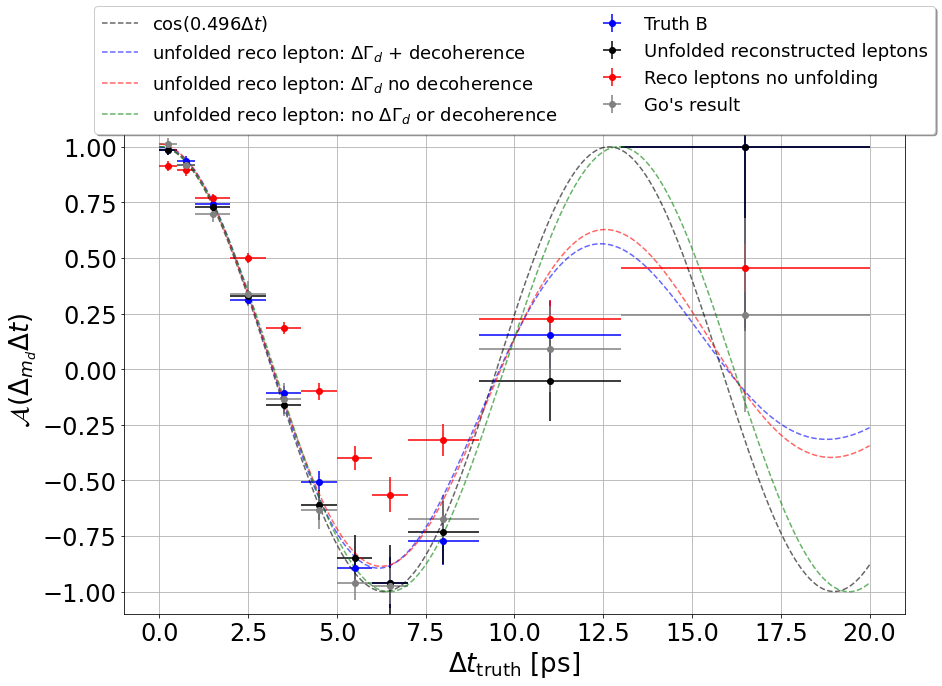

In [318]:
#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex = True, gridspec_kw={'hspace': 0.03, 'height_ratios': [3,1]})
fig,ax = plt.subplots(1,1,figsize=(14,9))
centers = [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5]
widths = np.array([0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])

ax.errorbar(centers,A_truth,A_truth_err,widths, 'o', color = 'blue', label = r"Truth B")
ax.errorbar(centers,A,A_err,widths, 'o', color = 'k', label = r"Unfolded reconstructed leptons")
ax.errorbar(centers,A_meas,A_meas_err,widths, 'o', color = 'red', label = r"Reco leptons no unfolding")
ax.errorbar(centers,A_go,A_go_err,widths, 'o', color = 'gray', label = "Go's result")

x = np.linspace(0,20,201)
ax.set_ylim(-1.1,1.1)
ax.plot(x, np.cos(0.496*x), 'k', linestyle = '--', label=r'$\cos(0.496\Delta t)$',alpha = 0.6)
ax.plot(x, md_all['amp']*np.cos(np.abs(md_all['md'])*x)*np.exp(-md_all['decoherence']*x)/np.cosh(md_all['width']*x/2),color = 'blue', linestyle = '--', alpha = 0.6, label = r'unfolded reco lepton: $\Delta \Gamma_d$ + decoherence')
ax.plot(x, mdw['amp']*np.cos(np.abs(mdw['md'])*x)/np.cosh(mdw['width']*x/2),color = 'red', linestyle = '--', alpha = 0.6, label = 'unfolded reco lepton: $\Delta \Gamma_d$ no decoherence')
ax.plot(x, md['amp']*np.cos(np.abs(md['md'])*x),color = 'green', linestyle = '--', alpha = 0.6, label = 'unfolded reco lepton: no $\Delta \Gamma_d$ or decoherence')
ax.set_ylabel(r'$\mathcal{A}(\Delta_{m_d}\Delta t)$')
ax.set_xlabel(r'$\Delta t_\mathrm{truth}$ [ps]')
ax.grid()
ax.legend(bbox_to_anchor=(1.05,1.26),fancybox=True,shadow=True,ncol=2)
plt.savefig('asymmetry_with_decoherence.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
def root_fit(plot_data, col = 'deltaT'): #fits cosine curve to data (asymmetry computed from binning)
    x1 = array.array('d', plot_data[col])
    x2 = array.array('d', plot_data['mcSumT'])
    y = array.array('d', plot_data['asymmetry'])
    gr = ROOT.TGraph(len(x1), x1, y)
    f = ROOT.TF1('f1', 'cos([0]*x)', 0, 20)
    #f.SetParLimits(0,0.1,0.9)
    gr.Fit('f1', 'SE')
    f2 = ROOT.TF2("f2","0.5*(cos([0]*x)+cos([0]*y))", 0, 20, 0, 250)
    f2.SetParLimits(0,0.1,0.9)
    gr2 = ROOT.TGraph2D(len(x1), x1, x2, y)
    gr2.Fit('f2', 'SE')
    fitdict = {"QM":f.GetParameter(0), "QM_err":f.GetParError(0), "SD":f2.GetParameter(0), "SD_err":f.GetParError(0)}
    return fitdict

In [ ]:
#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex = True, gridspec_kw={'hspace': 0.03, 'height_ratios': [3,1]})
fig,ax = plt.subplots(1,1,figsize=(12,7))
centers = [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5]
widths = np.array([0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
#ax[0].errorbar(centers,truth_deltaT['A_truth'],truth_deltaT_err['A_truth'],widths, 'o', label = r"Truth B")
#ax[0].errorbar(centers,truth_deltaT['A'],truth_deltaT_err['A'],widths, 'o', label = r"Reconstructed lepton: mistag frac %s"%(round(len(data.loc[data['mistag']==1])/len(data),4)))
#ax[0].errorbar(centers, 1/(1-2*len(data.loc[data['mistag']==1])/len(data))*truth_deltaT['A'], 1/(1-2*len(data.loc[data['mistag']==1])/len(data))*truth_deltaT_err['A'], widths, 'o', label=r'Scaled reconstructed lepton')

ax.errorbar(centers,A_truth,A_truth_err,widths, 'o', label = r"Truth B")
ax.errorbar(centers,A,A_err,widths, 'o', label = r"Unfolded reconstructed leptons")
ax.errorbar(centers,A_meas,A_meas_err,widths, 'o', label = r"Reco leptons no unfolding")

go = np.array([1.013, 0.916, 0.699, 0.339, -0.136, -0.634, -0.961, -0.974, -0.675, 0.089, 0.243])
go_err = np.array([0.028, 0.022, 0.038, 0.056, 0.075, 0.084, 0.077, 0.080, 0.109, 0.193, 0.435])
ax.errorbar(centers,go,go_err,widths, 'o', label = "Go's result")

x = np.linspace(0,17,201)
ax.set_ylim(-1.1,1.1)
ax.plot(x, np.cos(0.496*x), 'k', linestyle = '--', label=r'QM expectation $\Delta m_d = 0.496$',alpha = 0.3)
#plt.plot(x, np.cos(0.4496*x), 'red', linestyle = '--', label='SD least squares fit to truth MC')
#ax[1].bar(centers,truth_deltaT['mistag']/truth_deltaT['counts'],2*widths)
ax.set_ylabel(r'$\mathcal{A}(\Delta_{m_d}\Delta t)$')
#ax[1].set_ylabel(r'$w$')
ax.set_xlabel(r'$\Delta t_\mathrm{truth}$ [ps]')
ax.grid()
#ax[1].grid()
ax.legend(bbox_to_anchor=(.23,0.95),fancybox=True,shadow=True)
#plt.savefig('asymmetry_mistag_small.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
c1 = ROOT.TCanvas()
hRecoOF.SetStats(0)
hRecoOF.SetTitle("Unfold Response (OF)")
hRecoOF.GetXaxis().SetTitle(r'\Delta t  [ps]')
hRecoOF.GetXaxis().SetTitleSize(0.05)
hRecoOF.GetXaxis().SetLabelSize(0.05)
hRecoOF.GetYaxis().SetLabelSize(0.05)
hRecoOF.GetXaxis().SetTitleOffset(0.9)
hTrueOF.SetLineColor(2)
hRecoOF.SetLineColor(1)
hTrueOF.SetLineWidth(2)
hMeasOF.SetLineWidth(2)
hRecoOF.SetMarkerStyle(20)
hRecoOF.SetMarkerSize(0.5)
hRecoOF.Draw()
hTrueOF.Draw("same")
hMeasOF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueOF, "True distribution","pl")
leg.AddEntry(hMeasOF, "Measured distribution", "pl")
leg.AddEntry(hRecoOF, "Unfolded distribution")
leg.Draw()
c1.Draw()
#c1.SaveAs('OF_svd2.png')
#c1.SaveAs('OF_invert2.png')
#c1.SaveAs('OF_binbin2.png')
#c1.SaveAs('OF_bayes2.png')

In [ ]:
c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hRecoSF.SetTitle("Unfold Response (SF)")
hRecoSF.GetXaxis().SetTitle(r'\Delta t  [ps]')
hRecoSF.GetXaxis().SetTitleSize(0.05)
hRecoSF.GetXaxis().SetLabelSize(0.05)
hRecoSF.GetYaxis().SetLabelSize(0.05)
hRecoSF.GetYaxis().SetRangeUser(0,1250)
hRecoSF.GetXaxis().SetTitleOffset(0.9)
hTrueSF.SetLineColor(2)
hTrueSF.SetLineWidth(2)
hMeasSF.SetLineWidth(2)
hRecoSF.SetLineColor(1)
hRecoSF.SetMarkerStyle(20)
hRecoSF.SetMarkerSize(0.5)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()
#c1.SaveAs('SF_svd2.png')
#c1.SaveAs('SF_invert2.png')
#c1.SaveAs('SF_binbin2.png')
#c1.SaveAs('SF_bayes2.png')

In [ ]:
mistag = 1-2*len(data2.loc[data2['mistag']==1])/len(data2)

In [ ]:
vals = []
vals_meas = []
vals_truth = []
for i in range(1,12):
    try:
        vals.append((hRecoOF.GetBinContent(i)-hRecoSF.GetBinContent(i))/(hRecoOF.GetBinContent(i)+hRecoSF.GetBinContent(i)))
    except ZeroDivisionError:
        vals.append(0)
    try:
        vals_truth.append((hTrueOF.GetBinContent(i)-hTrueSF.GetBinContent(i))/(hTrueOF.GetBinContent(i)+hTrueSF.GetBinContent(i)))
    except ZeroDivisionError:
        vals_truth.append(0)
    try:
        vals_meas.append((hMeasOF.GetBinContent(i)-hMeasSF.GetBinContent(i))/(hMeasOF.GetBinContent(i)+hMeasSF.GetBinContent(i)))
    except ZeroDivisionError:
        vals_meas.append(0)

In [ ]:
vals_stat_err = []
for i in range(1,12):
    vals_stat_err.append(np.abs(vals[i-1])*np.sqrt((np.sqrt(np.sqrt(hRecoOF.GetBinContent(i))**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)-hRecoSF.GetBinContent(i)))**2+(np.sqrt(np.sqrt(hRecoOF.GetBinContent(i))**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)+hRecoSF.GetBinContent(i)))**2))
vals_stat_err = np.array(vals_stat_err)

In [ ]:
vals_stat_err = []
for i in range(1,12):
    vals_stat_err.append(np.abs(vals[i-1])*np.sqrt((np.sqrt(np.sqrt(hRecoOF.GetBinContent(i))**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)-hRecoSF.GetBinContent(i)))**2+(np.sqrt(np.sqrt(hRecoOF.GetBinContent(i))**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)+hRecoSF.GetBinContent(i)))**2))
vals_stat_err = np.array(vals_stat_err)
vals_sys_err = []
vals_meas_err = []
vals_truth_err = []
for i in range(1,12):
    vals_sys_err.append(np.abs(vals[i-1])*np.sqrt((np.sqrt(hRecoOF.GetBinError(i)**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)-hRecoSF.GetBinContent(i)))**2+(np.sqrt(hRecoOF.GetBinError(i)**2 + np.sqrt(hRecoSF.GetBinContent(i))**2)/(hRecoOF.GetBinContent(i)+hRecoSF.GetBinContent(i)))**2))
    vals_truth_err.append(np.abs(vals_truth[i-1])*np.sqrt((np.sqrt(hTrueOF.GetBinError(i)**2 + hTrueSF.GetBinError(i)**2)/(hTrueOF.GetBinContent(i)-hTrueSF.GetBinContent(i)))**2+(np.sqrt(hTrueOF.GetBinError(i)**2 + hTrueSF.GetBinError(i)**2)/(hTrueOF.GetBinContent(i)+hTrueSF.GetBinContent(i)))**2))
    vals_meas_err.append(np.abs(vals_meas[i-1])*np.sqrt((np.sqrt(hMeasOF.GetBinError(i)**2 + hMeasSF.GetBinError(i)**2)/(hMeasOF.GetBinContent(i)-hMeasSF.GetBinContent(i)))**2+(np.sqrt(hMeasOF.GetBinError(i)**2 + hMeasSF.GetBinError(i)**2)/(hMeasOF.GetBinContent(i)+hMeasSF.GetBinContent(i)))**2))
vals_sys_err = np.array(vals_sys_err)
vals_truth_err = np.array(vals_truth_err)
vals_meas_err = np.array(vals_meas_err)

In [ ]:
vals_err = np.sqrt(vals_stat_err**2 + vals_sys_err**2)

In [ ]:
1-2*len(data2.loc[data2['mistag']==1])/len(data2)

In [ ]:
vals_err = np.nan_to_num(vals_err)
vals_truth_err = np.nan_to_num(vals_truth_err)
vals_meas_err = np.nan_to_num(vals_meas_err)

In [ ]:
centers = [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5]
widths = np.array([0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
#x = [i+0.5 for i in range(0,13)]
#xerr = [0.5 for i in range(0,13)]
plt.errorbar(centers,vals,vals_err,widths,'o')
plt.errorbar(centers,vals_truth,vals_truth_err,widths,'o')
plt.errorbar(centers,vals_meas,vals_meas_err,widths,'o')

In [ ]:
def root_fit(A, A_err): #fits cosine curve to data (asymmetry computed from binning)
    #x1 = array.array('d', [i+0.5 for i in range(0,13)])
    x1 = array.array('d', [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5])
    y = array.array('d', A)
    #xerr = array.array('d', [0 for i in range(0,11)])
    #xerr = array.array('d', [0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
    xerr = array.array('d', [0 for i in range(0,11)])
    yerr = array.array('d', A_err)
    #gr = ROOT.TGraphErrors(len(x1), x1, y, xerr, yerr)
    #h = ROOT.TH1D('h1','h1',15,0,15)
    low_edges = [0,0.5,1,2,3,4,5,6,7,9,13,20]
    h = ROOT.TH1D('h1','h1',11,array.array('d',low_edges))
    for i in range(0,len(A)):
        h.SetBinContent(i+1,A[i])
        h.SetBinError(i+1,A_err[i])
    f = ROOT.TF1('f1', '[0]*cos([1]*x)', 0, 20)
    f.SetParLimits(0,0,1)
    f.SetParLimits(1,0,1)
    h.Fit('f1', 'SMRB')
    fitdict = {"amp":f.GetParameter(0), "amp_err":f.GetParError(0),
              "md":f.GetParameter(1), 'md_err':f.GetParError(1)}
    return fitdict

In [ ]:
print(root_fit(vals,vals_err))
#print(root_fit(vals_meas,vals_meas_err))
print(root_fit(vals_truth,vals_truth_err))

In [ ]:
truthOF['mistag'].sum()

In [ ]:
#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex = True, gridspec_kw={'hspace': 0.03, 'height_ratios': [3,1]})
fig,ax = plt.subplots(1,1,figsize=(12,7))
centers = [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5]
widths = np.array([0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
#ax[0].errorbar(centers,truth_deltaT['A_truth'],truth_deltaT_err['A_truth'],widths, 'o', label = r"Truth B")
#ax[0].errorbar(centers,truth_deltaT['A'],truth_deltaT_err['A'],widths, 'o', label = r"Reconstructed lepton: mistag frac %s"%(round(len(data.loc[data['mistag']==1])/len(data),4)))
#ax[0].errorbar(centers, 1/(1-2*len(data.loc[data['mistag']==1])/len(data))*truth_deltaT['A'], 1/(1-2*len(data.loc[data['mistag']==1])/len(data))*truth_deltaT_err['A'], widths, 'o', label=r'Scaled reconstructed lepton')

ax.errorbar(centers,vals_truth,vals_truth_err,widths, 'o', label = r"Truth B")
ax.errorbar(centers,vals,vals_err,widths, 'o', label = r"Unfolded reconstructed leptons")

go = np.array([1.013, 0.916, 0.699, 0.339, -0.136, -0.634, -0.961, -0.974, -0.675, 0.089, 0.243])
go_err = np.array([0.028, 0.022, 0.038, 0.056, 0.075, 0.084, 0.077, 0.080, 0.109, 0.193, 0.435])
ax.errorbar(centers,go,go_err,widths, 'o', label = "Go's result")

x = np.linspace(0,17,201)
ax.set_ylim(-1.1,1.1)
ax.plot(x, np.cos(0.496*x), 'k', linestyle = '--', label=r'QM expectation $\Delta m_d = 0.496$',alpha = 0.3)
#plt.plot(x, np.cos(0.4496*x), 'red', linestyle = '--', label='SD least squares fit to truth MC')
#ax[1].bar(centers,truth_deltaT['mistag']/truth_deltaT['counts'],2*widths)
ax.set_ylabel(r'$\mathcal{A}(\Delta_{m_d}\Delta t)$')
#ax[1].set_ylabel(r'$w$')
ax.set_xlabel(r'$\Delta t_\mathrm{truth}$ [ps]')
ax.grid()
#ax[1].grid()
ax.legend(bbox_to_anchor=(.23,0.95),fancybox=True,shadow=True)
#plt.savefig('asymmetry_mistag_small.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
def root_fit(plot_data, A, A_err): #fits cosine curve to data (asymmetry computed from binning)
    x1 = array.array('d', [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5])
    y = array.array('d', A)
    xerr = array.array('d', [0 for i in range(0,len(x1))])
    #xerr = array.array('d', [0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
    yerr = array.array('d', A_err)
    gr = ROOT.TGraphErrors(len(x1), x1, y, xerr, yerr)
    f = ROOT.TF1('f1', '[0]*cos(0.496*x)', 0, 16.5)
    gr.Fit('f1', 'SMRB')
    fitdict = {"Amp":f.GetParameter(0), "Amp_err":f.GetParError(0)}
    return fitdict

In [ ]:
root_fit(data,truth_deltaT['A'],truth_deltaT_err['A'])

In [ ]:
root_fit(data,truth_deltaT['A_truth'],truth_deltaT_err['A_truth'])

In [ ]:
1-2*len(data.loc[data['mistag']==1])/len(data)

## Dump

In [ ]:
#truthHistOF = ROOT.TH1F("fOF","fOF",15,0,15)
#measHistOF = ROOT.TH1F("gOF","gOF",15,0,15)
#truthHistSF = ROOT.TH1F("fSF","fSF",15,0,15)
#measHistSF = ROOT.TH1F("gSF","gSF",15,0,15)

low_edges = [0,0.5,1,2,3,4,5,6,7,9,13,20]
low_edges_sum = [0,6,12,20,30,45,70,110,150,200,280,400]
'''
truthHistOF = ROOT.TH1D("","",11,array.array('d',low_edges))
measHistOF = ROOT.TH1D("","",11,array.array('d',low_edges))
truthHistSF = ROOT.TH1D("","",11,array.array('d',low_edges))
measHistSF = ROOT.TH1D("","",11,array.array('d',low_edges))
response_OF = ROOT.RooUnfoldResponse(measHistOF,truthHistOF)
response_SF = ROOT.RooUnfoldResponse(measHistSF,truthHistSF)
'''

truthHistOF = ROOT.TH1D("","",11,array.array('d',low_edges_sum))
measHistOF = ROOT.TH1D("","",11,array.array('d',low_edges_sum))
truthHistSF = ROOT.TH1D("","",11,array.array('d',low_edges_sum))
measHistSF = ROOT.TH1D("","",11,array.array('d',low_edges_sum))
response_OF = ROOT.RooUnfoldResponse(measHistOF,truthHistOF)
response_SF = ROOT.RooUnfoldResponse(measHistSF,truthHistSF)

In [ ]:
'''
for i in range(0,min(len(dataOF),len(truthOF))):
    truthHistOF.Fill(truthOF['mcDeltaT'].iloc[i])
    measHistOF.Fill(truthOF['deltaT'].iloc[i])
    response_OF.Fill(truthOF['deltaT'].iloc[i],truthOF['mcDeltaT'].iloc[i])
for i in range(0,min(len(dataSF),len(truthSF))):
    truthHistSF.Fill(truthSF['mcDeltaT'].iloc[i])
    measHistSF.Fill(truthSF['deltaT'].iloc[i])
    response_SF.Fill(truthSF['deltaT'].iloc[i],truthSF['mcDeltaT'].iloc[i])
'''

for i in range(0,min(len(dataOF),len(truthOF))):
    truthHistOF.Fill(truthOF['mcSumT'].iloc[i])
    measHistOF.Fill(truthOF['sumT'].iloc[i])
    response_OF.Fill(truthOF['sumT'].iloc[i],truthOF['mcSumT'].iloc[i])
for i in range(0,min(len(dataSF),len(truthSF))):
    truthHistSF.Fill(truthSF['mcSumT'].iloc[i])
    measHistSF.Fill(truthSF['sumT'].iloc[i])
    response_SF.Fill(truthSF['sumT'].iloc[i],truthSF['mcSumT'].iloc[i])

In [ ]:
c = ROOT.TCanvas()
truthHistOF.SetStats(0)
truthHistOF.SetFillColorAlpha(7,0)
truthHistOF.SetLineColor(2)
truthHistOF.SetLineWidth(2)
measHistOF.SetLineWidth(2)
truthHistOF.Draw()
truthHistOF.SetTitle("OF Distributions")
truthHistOF.GetXaxis().SetTitle(r'\Delta t  [ps]')
truthHistOF.GetXaxis().SetTitleSize(0.05)
truthHistOF.GetXaxis().SetLabelSize(0.05)
truthHistOF.GetYaxis().SetLabelSize(0.05)
truthHistOF.GetXaxis().SetTitleOffset(0.9)
measHistOF.SetFillColorAlpha(42,0)
measHistOF.Draw("same")
leg = ROOT.TLegend(.55,0.7,.9,.9)
leg.AddEntry(truthHistOF,"True Distribution")
leg.AddEntry(measHistOF,"Measured")
leg.Draw()
c.Draw()
#c.SaveAs('OF.png')

In [ ]:
c1 = ROOT.TCanvas()
truthHistSF.SetStats(0)
truthHistSF.SetFillColorAlpha(7,0)
truthHistSF.SetLineColor(2)
truthHistSF.SetLineWidth(2)
measHistSF.SetLineWidth(2)
truthHistSF.Draw()
truthHistSF.SetTitle("SF Distributions")
truthHistSF.GetXaxis().SetTitle(r'\Delta t  [ps]')
truthHistSF.GetXaxis().SetTitleSize(0.05)
truthHistSF.GetXaxis().SetLabelSize(0.05)
truthHistSF.GetYaxis().SetLabelSize(0.05)
truthHistSF.GetXaxis().SetTitleOffset(0.9)
measHistSF.SetFillColorAlpha(42,0)
truthHistSF.Draw()
measHistSF.Draw("same")
leg = ROOT.TLegend(.55,0.7,.9,.9)
leg.AddEntry(truthHistSF,"True Distribution")
leg.AddEntry(measHistSF,"Measured")
leg.Draw()
c1.Draw()
#c1.SaveAs('SF.png')
ROF = response_OF.HresponseNoOverflow()
c2 = ROOT.TCanvas()
#ROOT.gPad.SetLogz()
ROF.SetStats(0)
ROF.Draw("colz")
ROF.SetTitle("Response (OF)")
ROF.GetXaxis().SetTitle(r'\Delta t_{meas} [ps]')
ROF.GetXaxis().SetTitleSize(0.05)
ROF.GetXaxis().SetLabelSize(0.05)
ROF.GetXaxis().SetTitleOffset(0.9)
ROF.GetYaxis().SetTitle(r'\Delta t_{truth} [ps]')
ROF.GetYaxis().SetTitleSize(0.05)
ROF.GetYaxis().SetLabelSize(0.05)
ROF.GetYaxis().SetTitleOffset(0.9)
c2.Draw()
#c2.SaveAs('Response_OF.png')
RSF = response_SF.HresponseNoOverflow()
c3 = ROOT.TCanvas()
#ROOT.gPad.SetLogz()
RSF.SetStats(0)
RSF.Draw("colz")
RSF.SetTitle("Response (SF)")
RSF.GetXaxis().SetTitle(r'\Delta t_{meas} [ps]')
RSF.GetXaxis().SetTitleSize(0.05)
RSF.GetXaxis().SetLabelSize(0.05)
RSF.GetXaxis().SetTitleOffset(0.9)
RSF.GetYaxis().SetTitle(r'\Delta t_{truth} [ps]')
RSF.GetYaxis().SetTitleSize(0.05)
RSF.GetYaxis().SetLabelSize(0.05)
RSF.GetYaxis().SetTitleOffset(0.9)
c3.Draw()
#c3.SaveAs('Response_SF.png')

In [ ]:
c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hTrueSF.SetLineColor(2)
hRecoSF.SetLineColor(1)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()

unfoldOF = ROOT.RooUnfoldInvert(response_OF, hMeasOF)
hRecoOF = unfoldOF.Hreco()

unfoldSF = ROOT.RooUnfoldInvert(response_SF, hMeasSF)
hRecoSF = unfoldSF.Hreco()

c1 = ROOT.TCanvas()
hRecoOF.SetStats(0)
hTrueOF.SetLineColor(2)
hRecoOF.SetLineColor(1)
hRecoOF.Draw()
hTrueOF.Draw("same")
hMeasOF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueOF, "True distribution","pl")
leg.AddEntry(hMeasOF, "Measured distribution", "pl")
leg.AddEntry(hRecoOF, "Unfolded distribution")
leg.Draw()
c1.Draw()

c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hTrueSF.SetLineColor(2)
hRecoSF.SetLineColor(1)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()

unfoldOF = ROOT.RooUnfoldBinByBin(response_OF, hMeasOF)
hRecoOF = unfoldOF.Hreco()
c1 = ROOT.TCanvas()
hRecoOF.SetStats(0)
hRecoOF.SetTitle("")
hTrueOF.SetLineColor(2)
hRecoOF.SetLineColor(1)
hRecoOF.Draw()
hTrueOF.Draw("same")
hMeasOF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueOF, "True distribution","pl")
leg.AddEntry(hMeasOF, "Measured distribution", "pl")
leg.AddEntry(hRecoOF, "Unfolded distribution")
leg.Draw()
c1.Draw()

unfoldSF = ROOT.RooUnfoldBinByBin(response_SF, hMeasSF)
hRecoSF = unfoldSF.Hreco()
c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hRecoSF.SetTitle("")
hTrueSF.SetLineColor(2)
hRecoSF.SetLineColor(1)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()

unfoldOF = ROOT.RooUnfoldBayes(response_OF, hMeasOF, 2)
hRecoOF = unfoldOF.Hreco()

unfoldSF = ROOT.RooUnfoldBayes(response_SF, hMeasSF, 2)
hRecoSF = unfoldSF.Hreco()

c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hTrueSF.SetLineColor(2)
hRecoSF.SetLineColor(1)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()

c1 = ROOT.TCanvas()
hRecoOF.SetStats(0)
hTrueOF.SetLineColor(2)
hRecoOF.SetLineColor(1)
hRecoOF.Draw()
hTrueOF.Draw("same")
hMeasOF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueOF, "True distribution","pl")
leg.AddEntry(hMeasOF, "Measured distribution", "pl")
leg.AddEntry(hRecoOF, "Unfolded distribution")
leg.Draw()
c1.Draw()
